In [1]:
import gymnasium as gym
from stable_baselines3 import SAC, TD3, A2C
import os
from gymnasium import RewardWrapper
import numpy as np

from gymnasium.wrappers import ClipAction

from langchain.schema.messages import HumanMessage, AIMessage
from langchain.memory import ConversationBufferMemory
from langchain.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.chains.llm import LLMChain
from langchain.chat_models import ChatOpenAI

# Basic Function Definitions

In [3]:
model_dir = "models"
log_dir = "logs"
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

def train(env, sb3_algo):
    # episode is 1000 steps
    if sb3_algo == 'SAC':
        model = SAC('MlpPolicy', env, verbose=0, device='cuda', tensorboard_log=log_dir)
    elif sb3_algo == 'TD3':
        model = TD3('MlpPolicy', env, verbose=0, device='cuda', tensorboard_log=log_dir)
    elif sb3_algo == 'A2C':
        model = A2C('MlpPolicy', env, verbose=0, device='cuda', tensorboard_log=log_dir)
    else:
        print('Algorithm not found')
        return

    TIMESTEPS = 25000
    iters = 0
    while True:
        iters += 1
        model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False)
        model.save(f"{model_dir}/{sb3_algo}_{TIMESTEPS*iters}")
def test(env, sb3_algo, path_to_model):
    if sb3_algo == 'SAC':
        model = SAC.load(path_to_model, env=env)
    elif sb3_algo == 'TD3':
        model = TD3.load(path_to_model, env=env)
    elif sb3_algo == 'A2C':
        model = A2C.load(path_to_model, env=env)
    else:
        print('Algorithm not found')
        return

    obs = env.reset()
    done = False
    extra_steps = 500
    while True:
        action, _ = model.predict(obs)
        obs, _, done, _ = env.step(action)
        
        # Print average reward on that step
        if done:
            extra_steps -= 1
            if extra_steps < 0:
                break


# Environment Setup

In [11]:
from gym import RewardWrapper
import matplotlib.pyplot as plt
env_name = 'Humanoid-v4'
env = gym.make(env_name, render_mode='Human')

step = 0
past_rewards = []

past_max_torso_position = [-9999]
def jump_reward(reward):
    global step, past_rewards, past_max_torso_position
    z_torso=env.state_vector()[0] #position of torso
    
    if z_torso < 0:
        salto = z_torso*5
    else:
        salto = z_torso*20 
        
    if z_torso > past_max_torso_position[-1]:
        past_max_torso_position.append(z_torso)

    reward=reward + salto
    past_rewards.append(reward) 
    # Every 1000 steps, print average reward
    if step % 1000 == 0:
        # we clear plots 
        print(f"Average reward: {np.mean(past_rewards[-1000:])}")
        print(f"Max torso position: {past_max_torso_position[-1]}\n")
        
    step += 1
    return reward


past_torso_positions = []
def jump_reward_2(reward):
    global step,past_max_torso_position, past_rewards, past_torso_positions
    step += 1
    z_torso = env.state_vector()[0]
    salto = 0
    
    if z_torso < 0:
        salto += z_torso*5
    else:
        # Avoid giving reward for holding position
        if len(past_torso_positions) > 10:
            if abs(past_torso_positions[-10] - z_torso) > 0.2:
                salto += z_torso*20
        
    if z_torso > past_max_torso_position[-1]:
        salto += z_torso*100
        past_max_torso_position.append(z_torso)
    
    # If it holds position, then penalize 
    if len(past_torso_positions) > 100:
        if z_torso- past_torso_positions[-100] < 0.3:
            salto -= 20 
            
    if step % 1000 == 0:
        past_torso_positions = []
        print(f"Average reward: {np.mean(past_rewards[-1000:])}")
        print(f"Max torso position: {past_max_torso_position[-1]}\n")
        
    reward = reward + salto
    past_rewards.append(reward) 
    return reward

def jump_reward_3(reward):
    global step, past_max_torso_position, past_rewards, past_torso_positions
    step += 1
    z_torso = env.state_vector()[0]
    jump_reward = 0
    
    # Reward for increasing height
    #height_increase = (z_torso - past_max_torso_position[-1] if past_max_torso_position else 0)
    height_increase = z_torso - (past_torso_positions[-1] if past_torso_positions else 0)
    if height_increase > 0 and z_torso > 0:
        jump_reward += height_increase * 100  # Increase multiplier as needed

    # Penalize for staying too low or static
    if len(past_torso_positions) > 10:
        if z_torso < 3:  # Define a threshold for low height
            jump_reward -= 5
        elif abs(past_torso_positions[-10] - z_torso) < 0.3:  # Not moving significantly
            jump_reward -= 10

    # Update past torso positions and max position
    past_torso_positions.append(z_torso)
    if z_torso > past_max_torso_position[-1]:
        past_max_torso_position.append(z_torso)

    # Penalize for unnatural postures if necessary
    # posture_penalty = calculate_posture_penalty(env)
    # jump_reward -= posture_penalty

    # Update reward
    reward += jump_reward
    past_rewards.append(reward)

    # Periodic logging
    if step % 1000 == 0:
        past_torso_positions = []
        print(f"Average reward: {np.mean(past_rewards[-1000:])}")
        print(f"Max torso position: {past_max_torso_position[-1]}\n")

    return reward 
     
    
    

env = gym.wrappers.TransformReward(env, jump_reward_3)
env.reset()
print()

/Users/erikdz/Library/Python/3.9/lib/python/site-packages/gymnasium/envs/registration.py:788: UserWarning: WARN: The environment is being initialised with render_mode='Human' that is not in the possible render_modes (['human', 'rgb_array', 'depth_array']).
  logger.warn(


# LLM

In [ ]:
os.environ["OPENAI_API_KEY"] = ...
gpt3 = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-16k")
gpt4 = ChatOpenAI(temperature=0.7, model_name="gpt-4-1106-preview")

def answer_dms(full_name, full_convo=None):
    
    input_template = """{0}"""
    system_template = """
    Given an objective, you write the code for the reward function of a humanoid robot. Here is the observation space available to you:
        | Num | Observation                                                                                                     | Min  | Max | Name (in corresponding XML file) | Joint | Unit                       |
    | --- | --------------------------------------------------------------------------------------------------------------- | ---- | --- | -------------------------------- | ----- | -------------------------- |
    | 0   | z-coordinate of the torso (centre)                                                                              | -Inf | Inf | root                             | free  | position (m)               |
    | 1   | x-orientation of the torso (centre)                                                                             | -Inf | Inf | root                             | free  | angle (rad)                |
    | 2   | y-orientation of the torso (centre)                                                                             | -Inf | Inf | root                             | free  | angle (rad)                |
    | 3   | z-orientation of the torso (centre)                                                                             | -Inf | Inf | root                             | free  | angle (rad)                |
    | 4   | w-orientation of the torso (centre)                                                                             | -Inf | Inf | root                             | free  | angle (rad)                |
    | 5   | z-angle of the abdomen (in lower_waist)                                                                         | -Inf | Inf | abdomen_z                        | hinge | angle (rad)                |
    | 6   | y-angle of the abdomen (in lower_waist)                                                                         | -Inf | Inf | abdomen_y                        | hinge | angle (rad)                |
    | 7   | x-angle of the abdomen (in pelvis)                                                                              | -Inf | Inf | abdomen_x                        | hinge | angle (rad)                |
    | 8   | x-coordinate of angle between pelvis and right hip (in right_thigh)                                             | -Inf | Inf | right_hip_x                      | hinge | angle (rad)                |
    | 9   | z-coordinate of angle between pelvis and right hip (in right_thigh)                                             | -Inf | Inf | right_hip_z                      | hinge | angle (rad)                |
    | 19  | y-coordinate of angle between pelvis and right hip (in right_thigh)                                             | -Inf | Inf | right_hip_y                      | hinge | angle (rad)                |
    | 11  | angle between right hip and the right shin (in right_knee)                                                      | -Inf | Inf | right_knee                       | hinge | angle (rad)                |
    | 12  | x-coordinate of angle between pelvis and left hip (in left_thigh)                                               | -Inf | Inf | left_hip_x                       | hinge | angle (rad)                |
    | 13  | z-coordinate of angle between pelvis and left hip (in left_thigh)                                               | -Inf | Inf | left_hip_z                       | hinge | angle (rad)                |
    | 14  | y-coordinate of angle between pelvis and left hip (in left_thigh)                                               | -Inf | Inf | left_hip_y                       | hinge | angle (rad)                |
    | 15  | angle between left hip and the left shin (in left_knee)                                                         | -Inf | Inf | left_knee                        | hinge | angle (rad)                |
    | 16  | coordinate-1 (multi-axis) angle between torso and right arm (in right_upper_arm)                                | -Inf | Inf | right_shoulder1                  | hinge | angle (rad)                |
    | 17  | coordinate-2 (multi-axis) angle between torso and right arm (in right_upper_arm)                                | -Inf | Inf | right_shoulder2                  | hinge | angle (rad)                |
    | 18  | angle between right upper arm and right_lower_arm                                                               | -Inf | Inf | right_elbow                      | hinge | angle (rad)                |
    | 19  | coordinate-1 (multi-axis) angle between torso and left arm (in left_upper_arm)                                  | -Inf | Inf | left_shoulder1                   | hinge | angle (rad)                |
    | 20  | coordinate-2 (multi-axis) angle between torso and left arm (in left_upper_arm)                                  | -Inf | Inf | left_shoulder2                   | hinge | angle (rad)                |
    | 21  | angle between left upper arm and left_lower_arm                                                                 | -Inf | Inf | left_elbow                       | hinge | angle (rad)                |
    | 22  | x-coordinate velocity of the torso (centre)                                                                     | -Inf | Inf | root                             | free  | velocity (m/s)             |
    | 23  | y-coordinate velocity of the torso (centre)                                                                     | -Inf | Inf | root                             | free  | velocity (m/s)             |
    | 24  | z-coordinate velocity of the torso (centre)                                                                     | -Inf | Inf | root                             | free  | velocity (m/s)             |
    | 25  | x-coordinate angular velocity of the torso (centre)                                                             | -Inf | Inf | root                             | free  | anglular velocity (rad/s)  |
    | 26  | y-coordinate angular velocity of the torso (centre)                                                             | -Inf | Inf | root                             | free  | anglular velocity (rad/s)  |
    | 27  | z-coordinate angular velocity of the torso (centre)                                                             | -Inf | Inf | root                             | free  | anglular velocity (rad/s)  |
    | 28  | z-coordinate of angular velocity of the abdomen (in lower_waist)                                                | -Inf | Inf | abdomen_z                        | hinge | anglular velocity (rad/s)  |
    | 29  | y-coordinate of angular velocity of the abdomen (in lower_waist)                                                | -Inf | Inf | abdomen_y                        | hinge | anglular velocity (rad/s)  |
    | 30  | x-coordinate of angular velocity of the abdomen (in pelvis)                                                     | -Inf | Inf | abdomen_x                        | hinge | aanglular velocity (rad/s) |
    | 31  | x-coordinate of the angular velocity of the angle between pelvis and right hip (in right_thigh)                 | -Inf | Inf | right_hip_x                      | hinge | anglular velocity (rad/s)  |
    | 32  | z-coordinate of the angular velocity of the angle between pelvis and right hip (in right_thigh)                 | -Inf | Inf | right_hip_z                      | hinge | anglular velocity (rad/s)  |
    | 33  | y-coordinate of the angular velocity of the angle between pelvis and right hip (in right_thigh)                 | -Inf | Inf | right_hip_y                      | hinge | anglular velocity (rad/s)  |
    | 34  | angular velocity of the angle between right hip and the right shin (in right_knee)                              | -Inf | Inf | right_knee                       | hinge | anglular velocity (rad/s)  |
    | 35  | x-coordinate of the angular velocity of the angle between pelvis and left hip (in left_thigh)                   | -Inf | Inf | left_hip_x                       | hinge | anglular velocity (rad/s)  |
    | 36  | z-coordinate of the angular velocity of the angle between pelvis and left hip (in left_thigh)                   | -Inf | Inf | left_hip_z                       | hinge | anglular velocity (rad/s)  |
    | 37  | y-coordinate of the angular velocity of the angle between pelvis and left hip (in left_thigh)                   | -Inf | Inf | left_hip_y                       | hinge | anglular velocity (rad/s)  |
    | 38  | angular velocity of the angle between left hip and the left shin (in left_knee)                                 | -Inf | Inf | left_knee                        | hinge | anglular velocity (rad/s)  |
    | 39  | coordinate-1 (multi-axis) of the angular velocity of the angle between torso and right arm (in right_upper_arm) | -Inf | Inf | right_shoulder1                  | hinge | anglular velocity (rad/s)  |
    | 40  | coordinate-2 (multi-axis) of the angular velocity of the angle between torso and right arm (in right_upper_arm) | -Inf | Inf | right_shoulder2                  | hinge | anglular velocity (rad/s)  |
    | 41  | angular velocity of the angle between right upper arm and right_lower_arm                                       | -Inf | Inf | right_elbow                      | hinge | anglular velocity (rad/s)  |
    | 42  | coordinate-1 (multi-axis) of the angular velocity of the angle between torso and left arm (in left_upper_arm)   | -Inf | Inf | left_shoulder1                   | hinge | anglular velocity (rad/s)  |
    | 43  | coordinate-2 (multi-axis) of the angular velocity of the angle between torso and left arm (in left_upper_arm)   | -Inf | Inf | left_shoulder2                   | hinge | anglular velocity (rad/s)  |
    | 44  | angular velocitty of the angle between left upper arm and left_lower_arm                                        | -Inf | Inf | left_elbow                       | hinge | anglular velocity (rad/s)  |
    
    Example code:
    ```
    step = 0
    past_rewards = []

    past_max_torso_position = [-9999]
    def jump_reward(reward):
        global step, past_rewards, past_max_torso_position
        z_torso=env.state_vector()[0] #position of torso
        
        if z_torso < 0:
            salto = z_torso*5
        else:
            salto = z_torso*20 
            
        if z_torso > past_max_torso_position[-1]:
            past_max_torso_position.append(z_torso)

        reward=reward + salto
        past_rewards.append(reward) 
        # Every 1000 steps, print average reward
        if step % 1000 == 0:
            # we clear plots 
            print(f"Average reward: {np.mean(past_rewards[-1000:])}")
            print(f"Max torso position: {past_max_torso_position[-1]}\n")
            
        step += 1
        return reward
    ```  
    
    EVERY EPISODE IS 1000 STEPS LONG, SO YOU CAN STORE DATA FROM PREVIOUS STEPS FOR THE NEXT STEP
    
    """
    
    memory = ConversationBufferMemory(
        llm=gpt3,
        memory_key="chat_history",
        return_messages=True,
        )
                
                
    messages = [
    SystemMessagePromptTemplate.from_template(system_template),
    MessagesPlaceholder(variable_name="chat_history"),
    HumanMessagePromptTemplate.from_template("{input}")
    ]
    prompt = ChatPromptTemplate.from_messages(messages=messages)

    chain = LLMChain(
    llm=gpt4,
    prompt=prompt,
    verbose=True,
    memory=memory,
    )
    
    
    user_prompt = input("> ")
    output = chain.run({"input":user_prompt})

# Training

In [12]:
# Rest of your code remains the same
if __name__ == '__main__':
    gymenv_name = 'Humanoid-v4'
    sb3_algo = 'SAC'
    path_to_model = './SAC_2500000.zip'

    train_model = True
    test_model = False

    if train_model:
        train(env, sb3_algo)

    if test_model:
        if os.path.isfile(path_to_model):
            test(env, sb3_algo, path_to_model=path_to_model)
        else:
            print(f'{path_to_model} not found.')



/Users/erikdz/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 6.09GB > 3.94GB
  warnings.warn(
/Users/erikdz/Library/Python/3.9/lib/python/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.state_vector to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.state_vector` for environment variables or `env.get_wrapper_attr('state_vector')` that will search the reminding wrappers.
  logger.warn(


Average reward: 0.21134739650968404
Max torso position: 0.20818408121114876

Average reward: 0.08930067023875869
Max torso position: 0.20818408121114876

Average reward: 0.18874687904237958
Max torso position: 0.39170452841599657

Average reward: 0.45623210211155085
Max torso position: 0.6025930217010363

Average reward: 0.7405012456246738
Max torso position: 0.71284107352107

Average reward: 1.1460145933077175
Max torso position: 0.71284107352107

Average reward: 0.9479935219619656
Max torso position: 0.7520851982242025

Average reward: 1.2398758207621363
Max torso position: 0.7520851982242025

Average reward: 1.3219818402259556
Max torso position: 0.7520851982242025

Average reward: 0.8033853289907151
Max torso position: 0.7520851982242025

Average reward: 1.478144516616228
Max torso position: 0.7520851982242025

Average reward: 1.490567335677845
Max torso position: 0.7520851982242025

Average reward: 1.5727486428056376
Max torso position: 0.7520851982242025

Average reward: 1.119277

KeyboardInterrupt: 

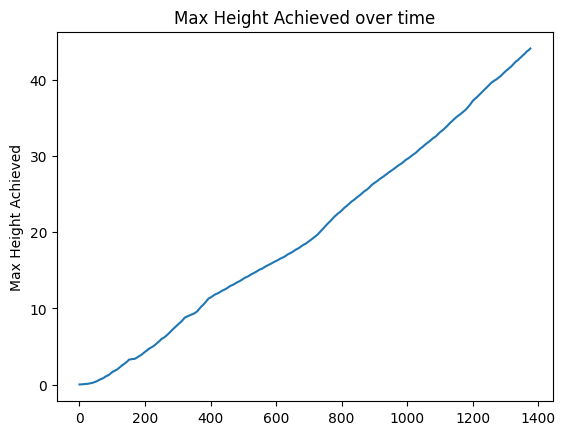

In [19]:
past_max_torso_position
past_max_torso_position_2 = past_max_torso_position[3:]
# We plot this 
import matplotlib.pyplot as plt
plt.plot(past_max_torso_position_2)
plt.ylabel('Max Height Achieved')
plt.title('Max Height Achieved recorded while training')
plt.show()